In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,  inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")
inspector = inspect(engine)

In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [6]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [7]:
# reflect an existing database into a new model
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# reflect the tables
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
first_row_m = session.query(measurement).first()
first_row_m.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x17c4bec04a8>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

In [12]:
last_row_m = session.query(measurement).order_by(measurement.id.desc()).first()
last_row_m.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x17c4bec0940>,
 'prcp': 0.45,
 'station': 'USC00516128',
 'tobs': 76.0,
 'date': '2017-08-23',
 'id': 19550}

In [13]:
session.query(measurement.date).order_by(measurement.date).first()

('2010-01-01')

In [14]:
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23')

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

In [16]:
# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)


Query Date:  2016-08-23


In [17]:
session.query(measurement.date).\
    filter(measurement.date > '2016-08-23').\
    order_by(measurement.date).count()

2223

In [18]:
# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).\
    order_by(measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
date_df = pd.DataFrame(results[:2223], columns=['date', 'prcp'])
date_df.set_index('date', inplace=True, )
date_df.head(10)


,prcp
date,
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45
2017-08-22,0.00
2017-08-22,0.00
2017-08-22,0.50
2017-08-21,0.00
2017-08-21,0.02


In [19]:
# Sort the dataframe by date
grouped_date_df = date_df.groupby('date', as_index = True)['prcp'].sum().to_frame('prcp').reset_index()
grouped_date_df.set_index('date')


,prcp
date,
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32
2016-08-28,3.10
...,...
2017-08-19,0.09
2017-08-20,0.01
2017-08-21,0.58


In [20]:
# Use Pandas Plotting with Matplotlib to plot the data
# x_axis = np.arange(len(grouped_date_df))
# tick_locations = [value for value in x_axis]
# plt.figure(figsize=(20,3));
# plt.bar(grouped_date_df["date"], grouped_date_df["prcp"],color='r', alpha=1, align="edge")
# plt.xticks(tick_locations, grouped_date_df["date"], rotation="vertical")
# plt.show()

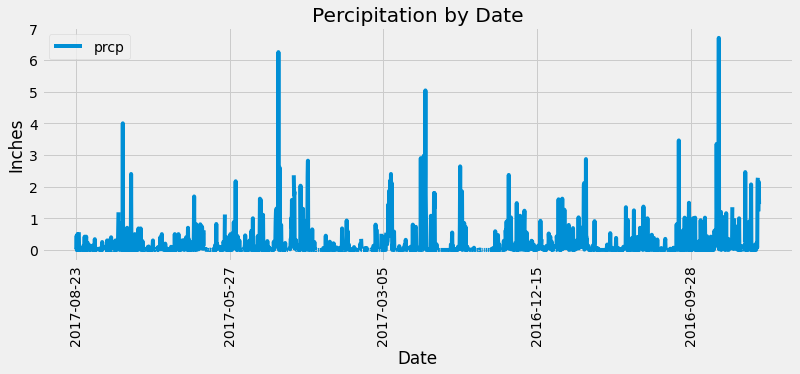

In [21]:
date_df.plot(figsize=(12,4), x_compat=True,rot=90, legend=True)
plt.title('Percipitation by Date')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.axis('tight')
plt.show()

In [22]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [30]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(station).count()
station_count

9

In [47]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
stations_act = session.query(measurement.station, measurement.date, measurement.prcp, measurement.tobs).\
    order_by(measurement.date.desc()).all()


In [68]:
station_act_df = pd.DataFrame(stations_act, columns=['station', 'date', 'prcp', 'tobs',])
station_act_df.head(10)

,station,date,prcp,tobs
0,USC00519397,2017-08-23,0.00,81.0
1,USC00514830,2017-08-23,0.00,82.0
2,USC00519523,2017-08-23,0.08,82.0
3,USC00516128,2017-08-23,0.45,76.0
4,USC00519397,2017-08-22,0.00,82.0
5,USC00519523,2017-08-22,0.00,82.0
6,USC00516128,2017-08-22,0.50,76.0
7,USC00519397,2017-08-21,0.00,81.0
8,USC00514830,2017-08-21,0.02,79.0
9,USC00519523,2017-08-21,NaN,82.0


In [74]:
grouped_station = station_act_df["station"].value_counts()
grouped_station

USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: station, dtype: int64

In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [ ]:
# Close Session
session.close()